# Line Fitting with APT

## Imports

In [3]:
from delfi.simulator.BaseSimulator import BaseSimulator
import os

import delfi.distribution as dd
import delfi.generator as dg
import numpy as np
import delfi.inference as infer
from delfi.summarystats.BaseSummaryStats import BaseSummaryStats
import copy
from mat4py import loadmat
import logging
import datetime
from scipy.io import savemat
import matplotlib.pyplot as plt
from delfi.utils.viz import samples_nd

## Simulator and Model

In [4]:
def linearNoiseSimulator(x, params, seed=None):
    alpha = params[0]
    beta = params[1]
    sigma = params[2]
    N = x.shape[0]
    #np.random.seed(123)
    y = x * alpha + beta + sigma * np.random.randn(N)

    return y
class linearNoiseModel(BaseSimulator):
    def __init__(self, x,dim_param, seed = None):


        super().__init__(dim_param=dim_param, seed=seed)
        self.x = x
        self.simulate = linearNoiseSimulator

    def gen_single(self, params):

        params = np.asarray(params)

        assert params.ndim == 1, 'params.ndim must be 1'

        hh_seed = self.gen_newseed()

        y = self.simulate(self.x, params, seed=hh_seed)

        return {'y': y.reshape(-1)}
class linearNoiseStats(BaseSummaryStats):

    def __init__(self,x):
        self.x = x
    def calc(self,repetition_list):
        seg = 100
        stats = []

        for r in range(len(repetition_list)):
            # data = repetition_list[r]
            # x = np.asarray(data['x'])
            # y = np.asarray(data['y'])

            # sum_stats_vec = np.concatenate((x,y))
            # stats.append(sum_stats_vec)
            data = repetition_list[r]
            x = self.x
            y = np.asarray(data['y'])
            N = x.shape[0]
            x_sorted = np.asarray([x for x,y in sorted(zip(x,y))])
            y_sorted = np.asarray([y for x,y in sorted(zip(x,y))])
            sum_stats_vec = []
            for i in np.arange(seg):
                ind = np.arange(i*int(N/seg),(i+1)*int(N/seg)).astype(int)
                y_min = np.min(y_sorted[ind])
                y_max = np.max(y_sorted[ind])
                sum_stats_vec.extend([x_sorted[ind[0]], x_sorted[ind[-1]], y_min,y_max])
            stats.append(sum_stats_vec)
        return stats

## Generate Data

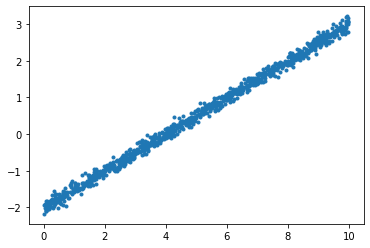

In [5]:
alpha = .5
beta = -2
sigma = 0.1
true_params = [alpha,beta,sigma]
labels_params = ['alpha','beta','sigma']
# generate observation
N = 1000
x0 = np.random.uniform(0, 10, N)

# define linear noise model
m = linearNoiseModel(x0,dim_param = 3)

# generate and show observation
obs0 = m.gen_single(true_params)
plt.figure()
plt.scatter(x0,obs0['y'], marker='.')

## Summary Statistics

In [6]:
class linearNoiseStats(BaseSummaryStats):

    def __init__(self,x):
        self.x = x
    def calc(self,repetition_list):
        seg = 100
        stats = []

        for r in range(len(repetition_list)):
            # data = repetition_list[r]
            # x = np.asarray(data['x'])
            # y = np.asarray(data['y'])

            # sum_stats_vec = np.concatenate((x,y))
            # stats.append(sum_stats_vec)
            data = repetition_list[r]
            x = self.x
            y = np.asarray(data['y'])
            N = x.shape[0]
            x_sorted = np.asarray([x for x,y in sorted(zip(x,y))])
            y_sorted = np.asarray([y for x,y in sorted(zip(x,y))])
            sum_stats_vec = []
            for i in np.arange(seg):
                ind = np.arange(i*int(N/seg),(i+1)*int(N/seg)).astype(int)
                y_min = np.min(y_sorted[ind])
                y_max = np.max(y_sorted[ind])
                sum_stats_vec.extend([x_sorted[ind[0]], x_sorted[ind[-1]], y_min,y_max])
            stats.append(sum_stats_vec)
        return stats

In [7]:
class linearNoiseStatsAlternate(BaseSummaryStats):
    
    def __init__(self, x):
        self.x = x
        
    def calc(self,repetition_list):
        stats = []
    
        for r in range(len(repetition_list)):
            data = repetition_list[r]
            y = np.asarray(data['y'])
            y_sorted = [yi for xi,yi in sorted(zip(self.x,y))]
            y_sorted = np.array(y_sorted)
            sum_stats_vec = []
            bins = np.linspace(y_sorted[0], y_sorted[-1], 50)
            digitized = np.digitize(y_sorted, bins, 'left')
            bin_means = [y_sorted[digitized == i].mean() for i in range(len(bins))]
            bin_vars = [y_sorted[digitized == i].var() for i in range(len(bins))]
            var = np.mean(bin_vars)
            stats.extend(bin_means)
            stats.extend(bin_vars)
            stats.append(var)
        return [stats]

In [8]:
prior_min = np.array([-10,-10,0])
prior_max = np.array([10,10,5])
seed_p = 2
prior =  dd.Uniform(lower = prior_min , upper = prior_max,seed = seed_p)

In [9]:
s = linearNoiseStats(x0)
g = dg.Default(model=m, prior=prior, summary=s)

# define statsitics summary of observation
obs_stats = s.calc([obs0])

In [10]:
# training schedule
n_train = 3000
n_rounds = 2
seed_inf = 1
pilot_samples = 2000

val_frac = 0.05
# network setup
n_hiddens = [200,50,50]
minibatch = 500
epochs = 100

prior_norm = True

# MAF parameters
density = 'maf'
n_mades = 5         # number of MADES

# inference object
res = infer.SNPEC(g,
                obs=obs_stats,
                n_hiddens=n_hiddens,
                seed=seed_inf,
                pilot_samples=pilot_samples,
                n_mades=n_mades,
                prior_norm=prior_norm,
                density=density)

# train
log, _, posterior = res.run(
                    n_train=n_train,
                    n_rounds=n_rounds,
                    minibatch=minibatch,
                epochs=epochs,
                silent_fail=False,
                proposal='prior',
                val_frac=val_frac,
                verbose=True,)

Stopping at epoch 89.0, training loss = -4.089907333531673, validation loss = -3.7168708258346657




Stopping at epoch 77.0, training loss = -5.19908278122399, validation loss = -5.236785333552617




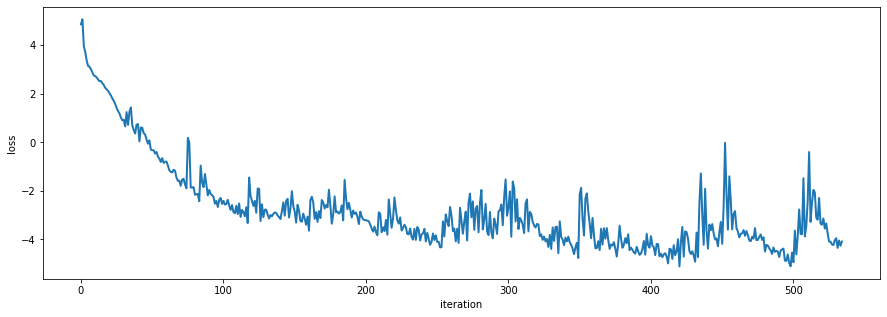

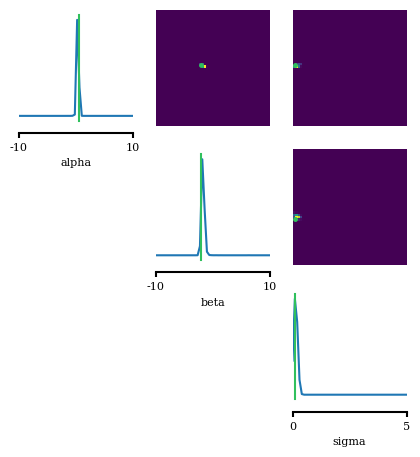

In [11]:
fig = plt.figure(figsize=(15,5))

plt.plot(log[0]['loss'],lw=2)
plt.xlabel('iteration')
plt.ylabel('loss')

prior_min = g.prior.lower
prior_max = g.prior.upper
prior_lims = np.concatenate((prior_min.reshape(-1,1),prior_max.reshape(-1,1)),axis=1)

posterior_samples = posterior[0].gen(10000)

###################
# colors
hex2rgb = lambda h: tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

# RGB colors in [0, 255]
col = {}
col['GT']      = hex2rgb('30C05D')
col['SNPE']    = hex2rgb('2E7FE8')
col['SAMPLE1'] = hex2rgb('8D62BC')
col['SAMPLE2'] = hex2rgb('AF99EF')

# convert to RGB colors in [0, 1]
for k, v in col.items():
    col[k] = tuple([i/255 for i in v])

###################
# posterior
fig, axes = samples_nd(posterior_samples,
                       limits=prior_lims,
                       ticks=prior_lims,
                       labels=labels_params,
                       fig_size=(5,5),
                       diag='kde',
                       upper='kde',
                       hist_diag={'bins': 50},
                       hist_offdiag={'bins': 50},
                       kde_diag={'bins': 50, 'color': col['SNPE']},
                       kde_offdiag={'bins': 50},
                       points=[true_params],
                       points_offdiag={'markersize': 5},
                       points_colors=[col['GT']],
                       title='');

In [30]:
np.random.seed(1223)
k = posterior[0].gen(100

In [31]:
k.flatten()

array([ 0.13748271, -1.31937665,  0.03324569,  0.45171856, -1.88610041,
        0.13073827])

In [32]:
k

array([[ 0.13748271, -1.31937665,  0.03324569],
       [ 0.45171856, -1.88610041,  0.13073827]])

In [38]:
kt = np.reshape(k, k.size, order='F').reshape(k.shape[1], k.shape[0])

In [39]:
kt[0]

array([0.13748271, 0.45171856])